<a href="https://colab.research.google.com/github/philipplozovoy/covid19_max_team_productivity/blob/master/max_team_productivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Assumptions
# 1) carantine period - april and may 
working_weeks = 8
working_days = working_weeks*5
# sick days equal to 2 working weeks
sick_days = 10
# 2) work at home is less productive than work at office
# coefficients from personal history
work_at_home_coef = 0.75
work_at_office_coef = 1
# for some reasons our team can only do most of the work from the office
# so we need penalty for zero days at office
penalty_no_office = 0.8
# 3) one team member utilize 0.6 SP per one working day at office
# jira history
sp_per_day = 0.6
# 4) possibility to become sick is 4%
# 14000 test in Moscow https://www.mos.ru/news/item/72148073/
# 500 cases in Moscow https://yandex.ru/search/?text=%D0%BA%D0%BE%D1%80%D0%BE%D0%BD%D0%B0%D0%B2%D0%B8%D1%80%D1%83%D1%81&query_source=share&type=covid19&lr=213
# 500/14000 is about 4%
possibility_sick = 0.04
# 5) possibility to death when sick is 4%
# possibility of death is about 4% https://www.rbc.ru/rbcfreenews/5e5e9fc19a79474e88d1a5db
possibility_death = 0.04

In [0]:
def possible_days_to_get_sick():
    return np.random.random(size=working_days) <= possibility_sick

def working_days_units(days):
    """Calculate working days units - estimation of real working time
    :param days: an array of working days where 1 - at office, 0 - at home
    :type days: array
    :return: number of working days units
    """
    working_days_office = np.sum(days) 
    working_days_home = len(days) - working_days_office
    return working_days_office*work_at_office_coef + working_days_home*work_at_home_coef

def calc_results(tm_office):
    """Calculate working days when a team member is healthy, sick and dead
    :param tm_office: an array of days when a team member go to office
    :type tm_office: array
    :return: number of healthy working days
    """
    array_of_sick = tm_office * possible_days_to_get_sick()
    sick = np.where(np.sum(array_of_sick) > 0, 1, 0)
    death = (sick * np.random.random()) >= (1 - possibility_death)
    if np.sum(array_of_sick) == 0:
        wd_real = working_days_units(tm_office)
    else:
        wd_before_sick = np.min(np.where(array_of_sick == 1)) + 1
        if death:
            wd_real = working_days_units(tm_office[:wd_before_sick])
        elif wd_before_sick + sick_days >= working_days:
            wd_real = working_days_units(tm_office[:wd_before_sick])
        else: 
            wd_real = working_days_units(tm_office[:wd_before_sick]) \
            + working_days_units(tm_office[wd_before_sick+sick_days:])
    return wd_real, sick, death

n_simulations = 100000
bs_sp_done = np.empty(n_simulations)
bs_sick = np.empty(n_simulations)
bs_death = np.empty(n_simulations)

def draw_bs_stats():
  """Draw bootstrap stats from tm_office_i"""
  for i in range(n_simulations):
    wdu_1, sick_1, death_1 = calc_results(tm_office_1)
    wdu_2, sick_2, death_2 = calc_results(tm_office_2)
    wdu_3, sick_3, death_3 = calc_results(tm_office_3)
    wdu_4, sick_4, death_4 = calc_results(tm_office_4)
    wdu_5, sick_5, death_5 = calc_results(tm_office_5)

    bs_sp_done[i] = (wdu_1 + wdu_2 + wdu_3 + wdu_4 + wdu_5) * sp_per_day
    bs_sick[i] = sick_1 + sick_2 + sick_3 + sick_4 + sick_5
    bs_death[i] = death_1 + death_2 + death_3 + death_4 + death_5
  return bs_sp_done, bs_sick, bs_death  


In [0]:
# Case 1 - zero days at office 
tm_office_1 = np.tile(np.array([0, 0, 0, 0, 0]),working_weeks)
tm_office_2 = np.tile(np.array([0, 0, 0, 0, 0]),working_weeks)
tm_office_3 = np.tile(np.array([0, 0, 0, 0, 0]),working_weeks)
tm_office_4 = np.tile(np.array([0, 0, 0, 0, 0]),working_weeks)
tm_office_5 = np.tile(np.array([0, 0, 0, 0, 0]),working_weeks)

bs_sp_done, bs_sick, bs_death = draw_bs_stats()

mean_sp_office = [np.mean(bs_sp_done)*(1-penalty_no_office)]
mean_sick_office = [np.mean(bs_sick)]
mean_no_sick_office = [np.mean(np.where(bs_sick > 0, 0, 1))]
mean_death_office = [np.mean(bs_death)]

In [0]:
# Case 2 - 1 day at office
tm_office_1 = np.tile(np.array([1, 0, 0, 0, 0]),working_weeks)
tm_office_2 = np.tile(np.array([0, 1, 0, 0, 0]),working_weeks)
tm_office_3 = np.tile(np.array([0, 0, 1, 0, 0]),working_weeks)
tm_office_4 = np.tile(np.array([0, 0, 0, 1, 0]),working_weeks)
tm_office_5 = np.tile(np.array([0, 0, 0, 0, 1]),working_weeks)

bs_sp_done, bs_sick, bs_death = draw_bs_stats()
  
mean_sp_office.append(np.mean(bs_sp_done))
mean_sick_office.append(np.mean(bs_sick))
mean_no_sick_office.append(np.mean(np.where(bs_sick > 0, 0, 1)))
mean_death_office.append(np.mean(bs_death))

In [0]:
# Case 3 - 2 day at office
tm_office_1 = np.tile(np.array([1, 1, 0, 0, 0]),working_weeks)
tm_office_2 = np.tile(np.array([0, 1, 1, 0, 0]),working_weeks)
tm_office_3 = np.tile(np.array([0, 0, 1, 1, 0]),working_weeks)
tm_office_4 = np.tile(np.array([0, 0, 0, 1, 1]),working_weeks)
tm_office_5 = np.tile(np.array([0, 0, 0, 1, 1]),working_weeks)

bs_sp_done, bs_sick, bs_death = draw_bs_stats()

mean_sp_office.append(np.mean(bs_sp_done))
mean_sick_office.append(np.mean(bs_sick))
mean_no_sick_office.append(np.mean(np.where(bs_sick > 0, 0, 1)))
mean_death_office.append(np.mean(bs_death))

In [0]:
# Case 4 - 3 day at office
tm_office_1 = np.tile(np.array([1, 1, 1, 0, 0]),working_weeks)
tm_office_2 = np.tile(np.array([0, 1, 1, 1, 0]),working_weeks)
tm_office_3 = np.tile(np.array([0, 0, 1, 1, 1]),working_weeks)
tm_office_4 = np.tile(np.array([0, 0, 1, 1, 1]),working_weeks)
tm_office_5 = np.tile(np.array([0, 0, 1, 1, 1]),working_weeks)

bs_sp_done, bs_sick, bs_death = draw_bs_stats()

mean_sp_office.append(np.mean(bs_sp_done))
mean_sick_office.append(np.mean(bs_sick))
mean_no_sick_office.append(np.mean(np.where(bs_sick > 0, 0, 1)))
mean_death_office.append(np.mean(bs_death))

In [0]:
# Case 5 - 4 day at office
tm_office_1 = np.tile(np.array([1, 1, 1, 1, 0]),working_weeks)
tm_office_2 = np.tile(np.array([0, 1, 1, 1, 1]),working_weeks)
tm_office_3 = np.tile(np.array([0, 1, 1, 1, 1]),working_weeks)
tm_office_4 = np.tile(np.array([1, 0, 1, 1, 1]),working_weeks)
tm_office_5 = np.tile(np.array([1, 0, 1, 1, 1]),working_weeks)

bs_sp_done, bs_sick, bs_death = draw_bs_stats()

mean_sp_office.append(np.mean(bs_sp_done))
mean_sick_office.append(np.mean(bs_sick))
mean_no_sick_office.append(np.mean(np.where(bs_sick > 0, 0, 1)))
mean_death_office.append(np.mean(bs_death))

In [0]:
# Case 6 - 5 day at office
tm_office_1 = np.tile(np.array([1, 1, 1, 1, 1]),working_weeks)
tm_office_2 = np.tile(np.array([1, 1, 1, 1, 1]),working_weeks)
tm_office_3 = np.tile(np.array([1, 1, 1, 1, 1]),working_weeks)
tm_office_4 = np.tile(np.array([1, 1, 1, 1, 1]),working_weeks)
tm_office_5 = np.tile(np.array([1, 1, 1, 1, 1]),working_weeks)

bs_sp_done, bs_sick, bs_death = draw_bs_stats()

mean_sp_office.append(np.mean(bs_sp_done))
mean_sick_office.append(np.mean(bs_sick))
mean_no_sick_office.append(np.mean(np.where(bs_sick > 0, 0, 1)))
mean_death_office.append(np.mean(bs_death))

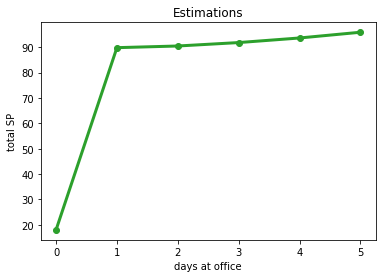

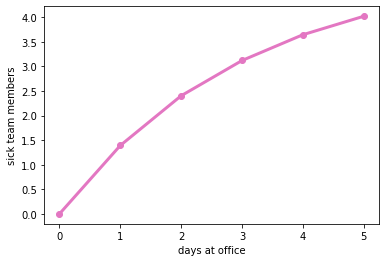

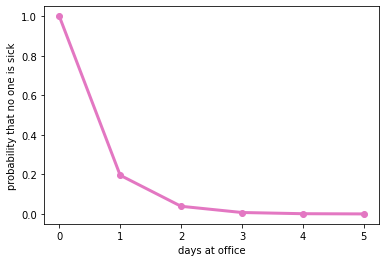

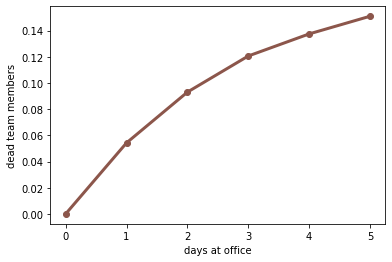

In [24]:
days_in_office = np.arange(6)
_ = plt.title('Estimations')
_ = plt.plot(days_in_office, mean_sp_office, marker='.', linewidth=3, markersize=12, color='tab:green')
_ = plt.xlabel('days at office')
_ = plt.ylabel('total SP')
plt.show()
_ = plt.plot(days_in_office, mean_sick_office, marker='.', linewidth=3, markersize=12, color='tab:pink')
_ = plt.xlabel('days at office')
_ = plt.ylabel('sick team members')
plt.show()
_ = plt.plot(days_in_office, mean_no_sick_office, marker='.',linewidth=3, markersize=12, color='tab:pink')
_ = plt.xlabel('days at office')
_ = plt.ylabel('probability that no one is sick')
plt.show()
_ = plt.plot(days_in_office, mean_death_office, marker='.',linewidth=3, markersize=12, color='tab:brown')
_ = plt.xlabel('days at office')
_ = plt.ylabel('dead team members')
plt.show()